In [2]:
from torch.utils.cpp_extension import load
import torch
import random
import statistics
import matplotlib.pyplot as plt

from collections import defaultdict

bench = load(name="bench", sources=["file.cpp", "bench.cu"], extra_cuda_cflags=["--keep", "--keep-dir", "/workspace/benchmarks/temp", "--extended-lambda"], verbose=True)

outs = torch.zeros((1024*32), dtype=torch.int32, device="cuda")

results = defaultdict(lambda:defaultdict(list))

dtypes = ["float32", "int32", "uint32", "half2", "double", "int64"]
ops = ["add", "inc", "max", "xor", "or", "exch", "mul", "add_manual", "add_nochange", "add_warpcoalesced"]

for op, op_name in enumerate(ops):
    for dtype_enum, dtype in enumerate(dtypes):
        if bench.bench(dtype_enum, outs, op, 128, 128, 0) == 1:
            continue
        # if dtype not in ("int32", "inc", "float32"): continue
        for n_threads in (32, 64, 128, 256, 512, 1024):
            if n_threads not in (256,): continue
            for shmem_size in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
                if shmem_size > n_threads: continue
                clocks = []
                for i in range(100):
                    outs.zero_()
                    result = bench.bench(dtype_enum, outs, op, shmem_size, n_threads, 0)
                    if result == 1:
                        print(f"No kernel for ")
                        break

                    outs_list = [int(a) for a in outs[:n_threads*128//32].tolist()]
                    if outs_list.count(-1) != 0:
                        print(f"FOUND {outs_list.count(-1)} -1 VALUES!!!")
                        print(outs_list)
                        raise AssertionError
                    elif outs_list.count(0) != 0:
                        print(f"FOUND {outs_list.count(0)} 0 VALUES")
                        print(outs_list)
                        raise AssertionError

                    clocks.extend(outs_list)
                if not clocks: continue
                mean = int(statistics.mean(clocks))
                print(f"FOR {dtype=}\top={op_name}\titerations=512\t{shmem_size=}\t{n_threads=}\tmean: {mean}")
                results[n_threads][f"{op_name}_{dtype}"].append(mean)
                if mean < 1000:
                    pass # print("\n\nTHIS OP AND DTYPE ARE PROBABLY EMPTY\n\n")

            # print(f"{results=}")

results = dict(results)


Using /root/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module bench, skipping build step...
Loading extension module bench...


FOR dtype='float32'	op=add	iterations=512	shmem_size=1	n_threads=256	mean: 7160057
FOR dtype='float32'	op=add	iterations=512	shmem_size=2	n_threads=256	mean: 3763122
FOR dtype='float32'	op=add	iterations=512	shmem_size=4	n_threads=256	mean: 1818050
FOR dtype='float32'	op=add	iterations=512	shmem_size=8	n_threads=256	mean: 924101
FOR dtype='float32'	op=add	iterations=512	shmem_size=16	n_threads=256	mean: 461351
FOR dtype='float32'	op=add	iterations=512	shmem_size=32	n_threads=256	mean: 190811
FOR dtype='float32'	op=add	iterations=512	shmem_size=64	n_threads=256	mean: 128214
FOR dtype='float32'	op=add	iterations=512	shmem_size=128	n_threads=256	mean: 92261
FOR dtype='float32'	op=add	iterations=512	shmem_size=256	n_threads=256	mean: 48971
RUNNING NOTHING for op=0 dtype=1
FOR dtype='uint32'	op=add	iterations=512	shmem_size=1	n_threads=256	mean: 126395
FOR dtype='uint32'	op=add	iterations=512	shmem_size=2	n_threads=256	mean: 63332
FOR dtype='uint32'	op=add	iterations=512	shmem_size=4	n_thre

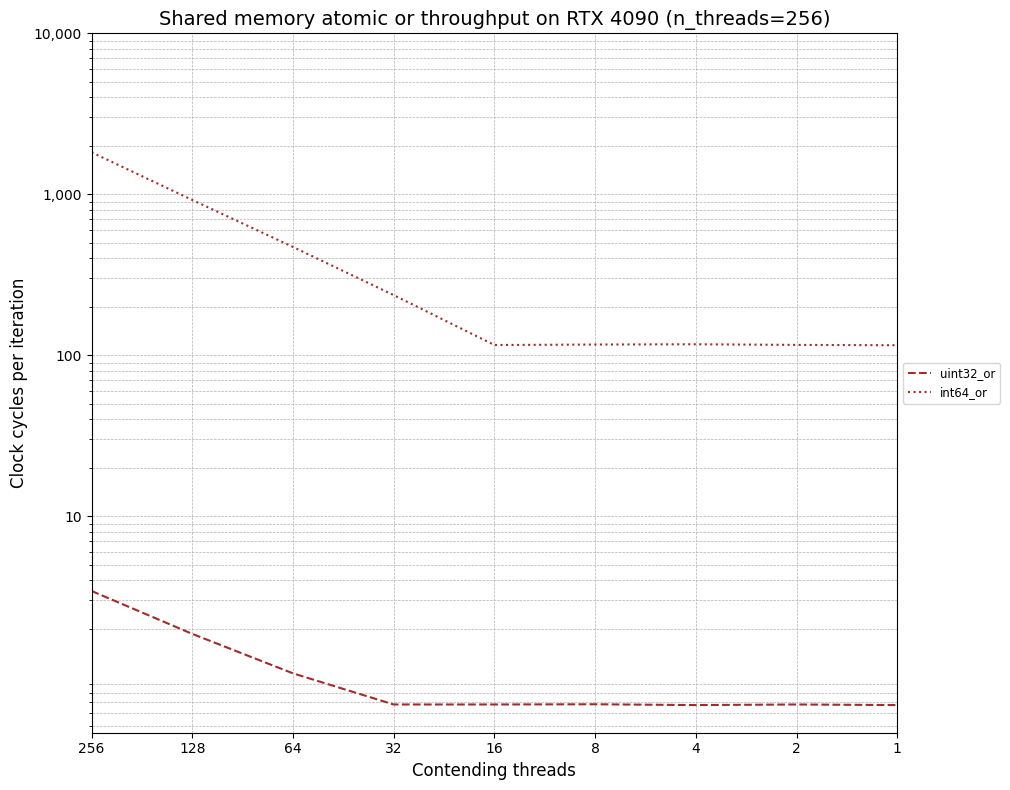

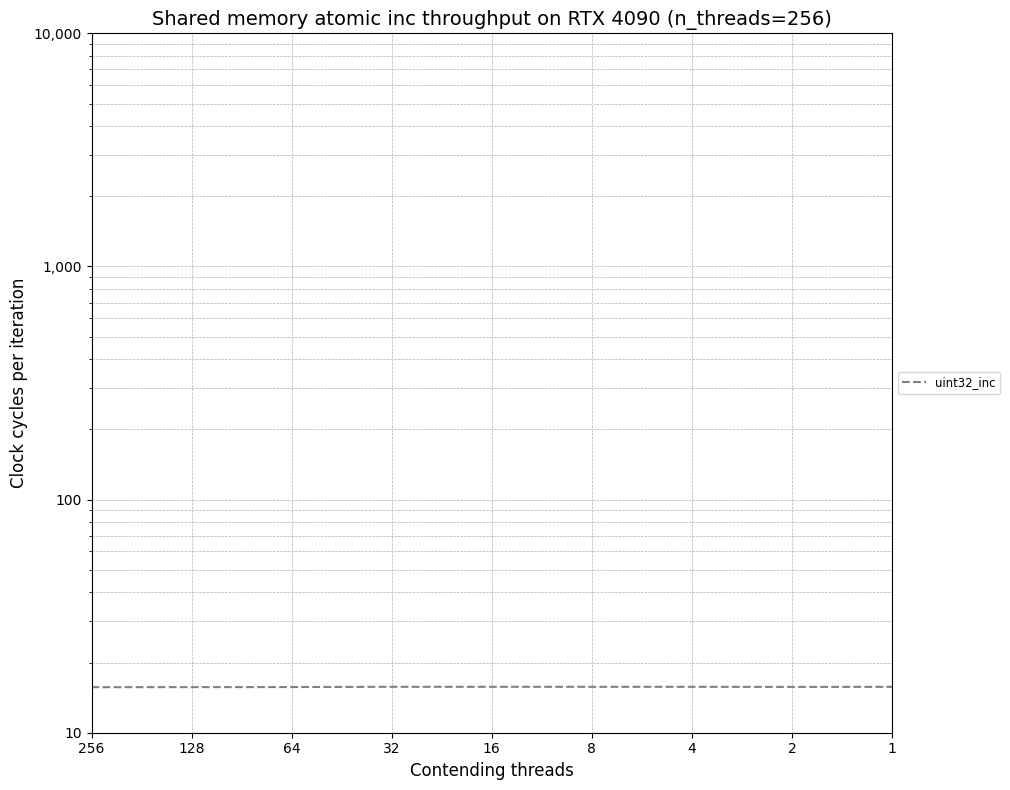

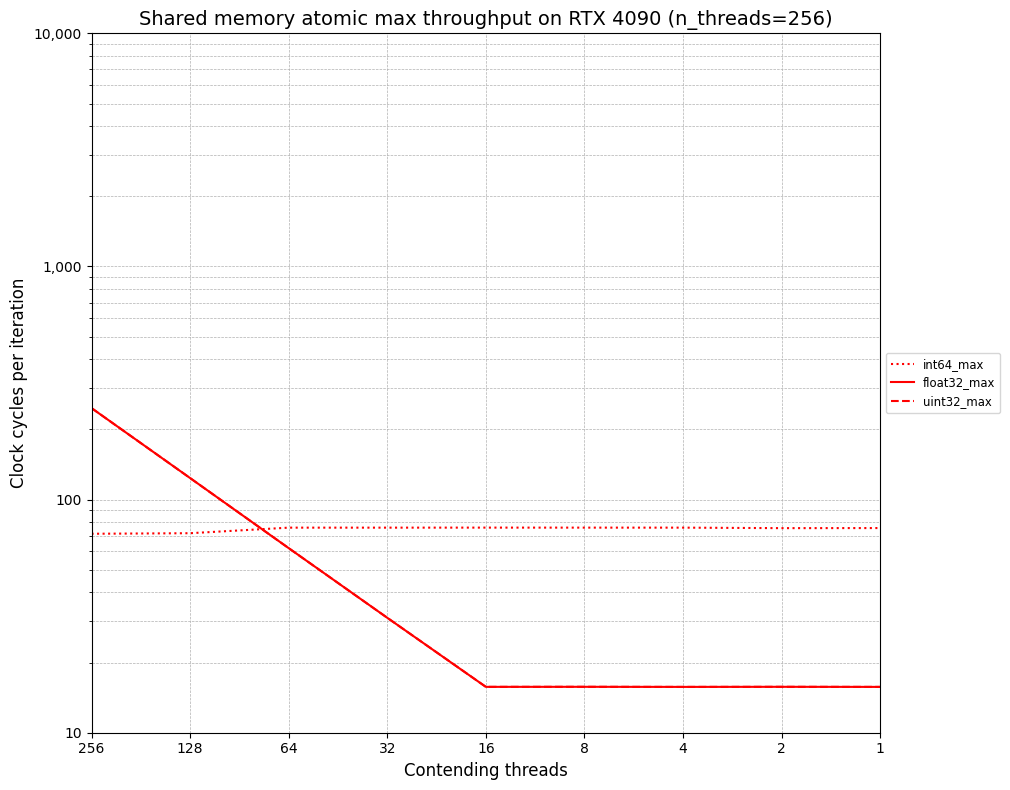

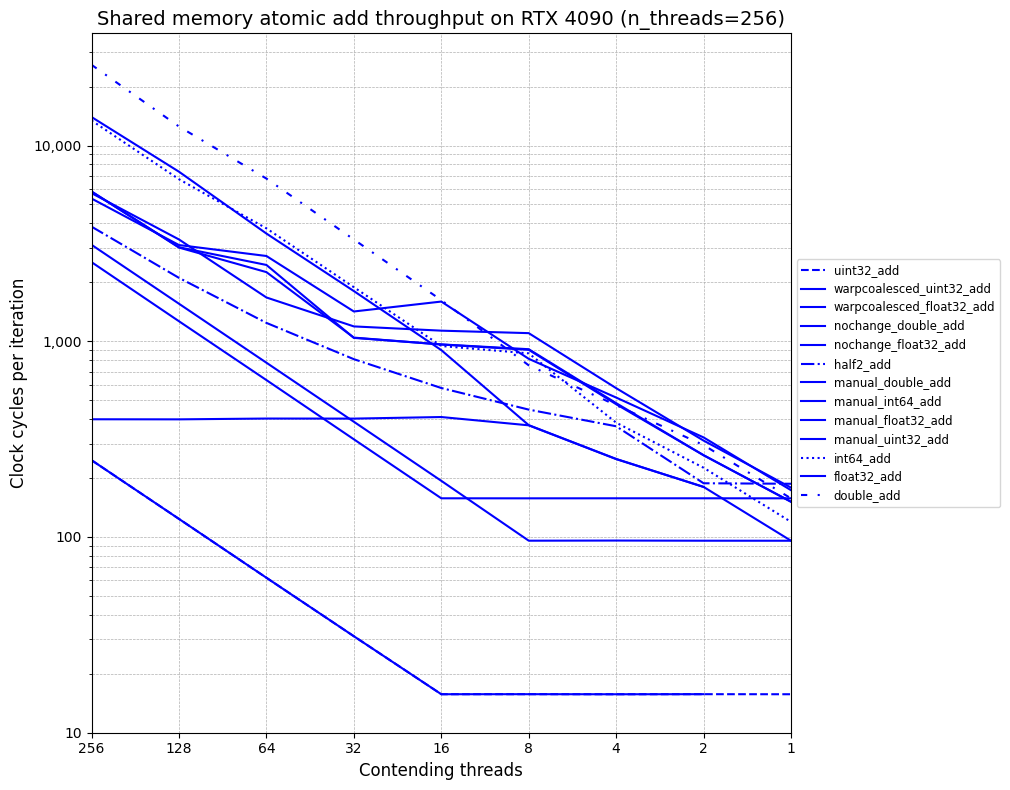

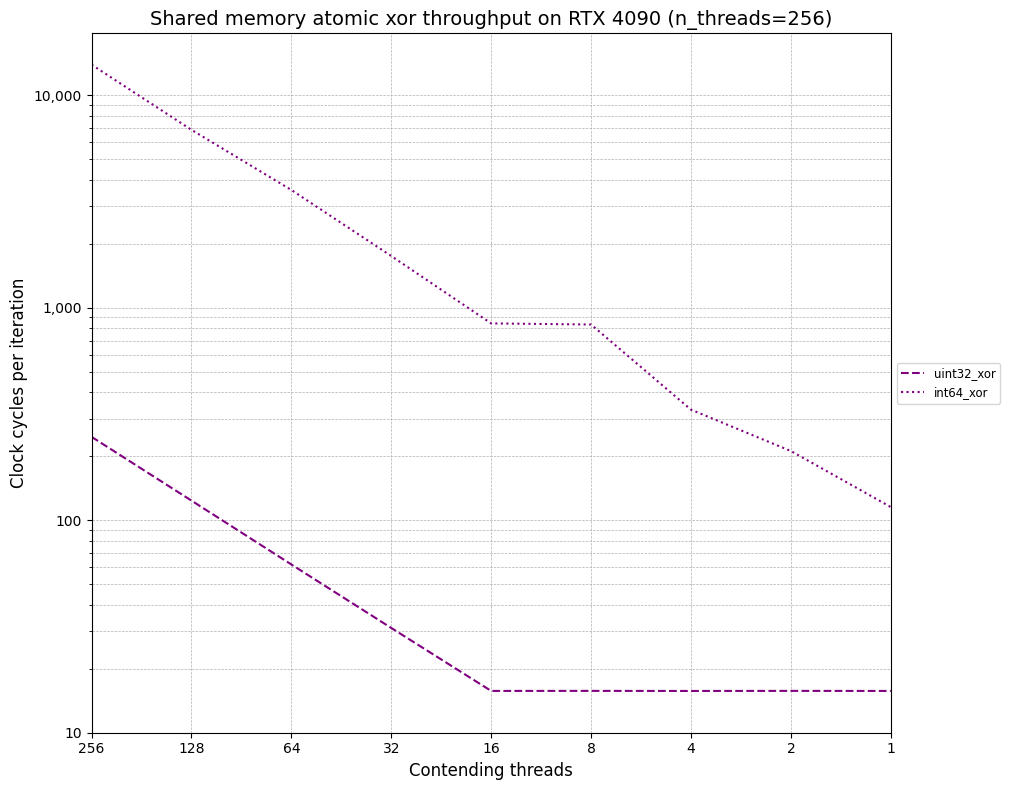

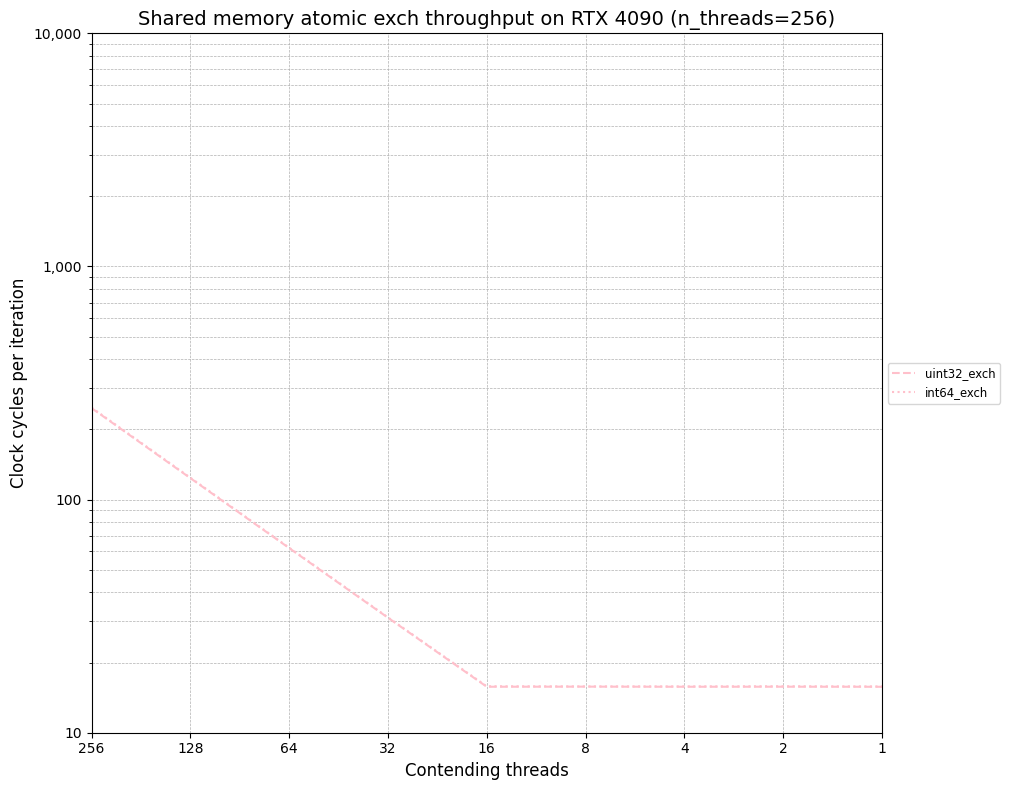

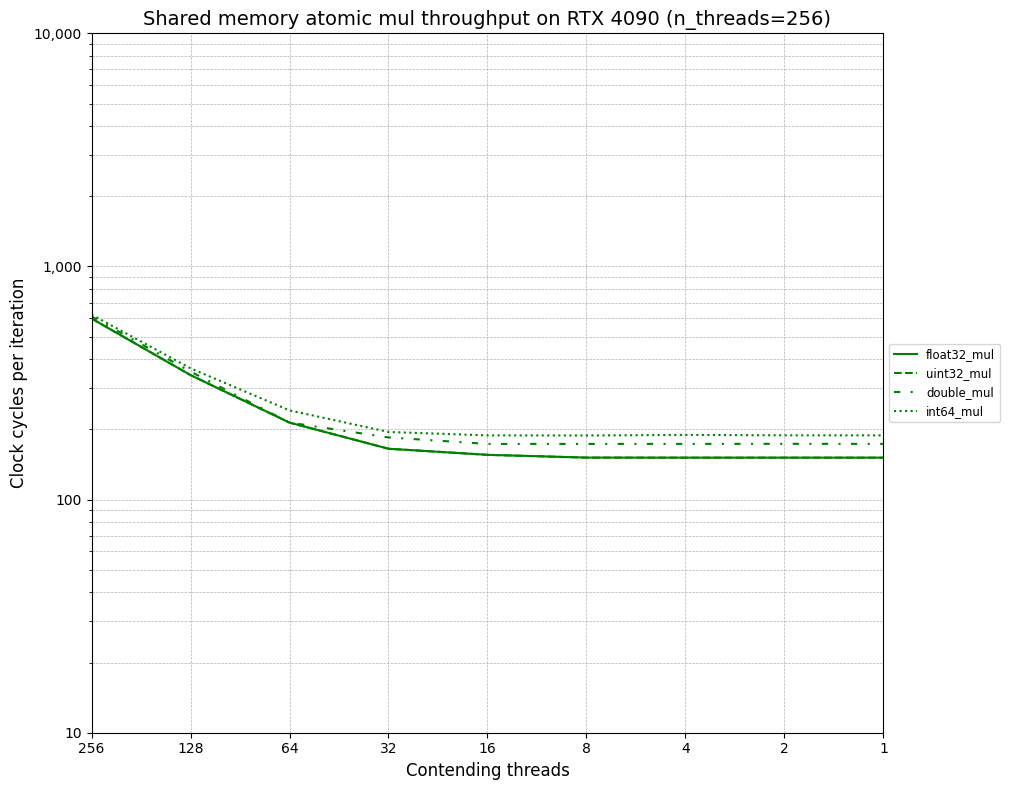

In [3]:
import math
import matplotlib.pyplot as plt
from collections import defaultdict

operation_colors = {
    "add": "blue",
    # "manualadd": "orange",
    "mul": "green",
    "max": "red",
    "xor": "purple",
    "or": "brown",
    "exch": "pink",
    "inc": "gray"
}

# Define line styles for each dtype
dtype_styles = {
    "float32": "solid",
    "uint32": "dashed",
    "int64": "dotted",
    "half2": "dashdot",
    "double": (0, (3, 5, 1, 5))  # Custom dash pattern
}

def parse_key(key):
    return key.split("_")

for n_threads in (256,):
    values = list(results[n_threads].items())
    values.sort(key=lambda a: a[1][0])
    n_values = math.ceil(math.log2(n_threads) + 1)

    grouped_lines = defaultdict(list)
    for dtype_op, data in values:
        if dtype_op.startswith("add_"):
            grouped_lines["add"].append(("_".join(dtype_op.split("_")[1:]), data))
        else:
            op, dtype = dtype_op.split("_")
            grouped_lines[op].append((dtype, data))

    for op, data_list in grouped_lines.items():
        plt.figure(figsize=(12, 8))  # Set a larger figure size for better legibility

        for dtype, data in data_list:
            color = operation_colors[op]
            linestyle = dtype_styles.get(dtype, "solid")
            plt.plot([a / 512 for a in data[:n_values]], label=f"{dtype}_{op}", color=color, linestyle=linestyle)

        plt.title(f"Shared memory atomic {op} throughput on RTX 4090 (n_threads={n_threads})", fontsize=14)
        plt.ylabel("Clock cycles per iteration", fontsize=12)
        plt.xlabel("Contending threads", fontsize=12)
        plt.yscale("log")
        plt.xticks(list(range(n_values)), [math.ceil(n_threads / (2**i)) for i in range(n_values)], fontsize=10)
        plt.yticks([10, 100, 1000, 10000], ["10", "100", "1,000", "10,000"], fontsize=10)
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)

        # Adjust x-axis limits to remove whitespace
        plt.xlim(0, n_values - 1)

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)

        plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legends

        plt.show()


grouped_lines.keys()=dict_keys(['standard', 'warpcoalesced', 'nochange', 'manual'])


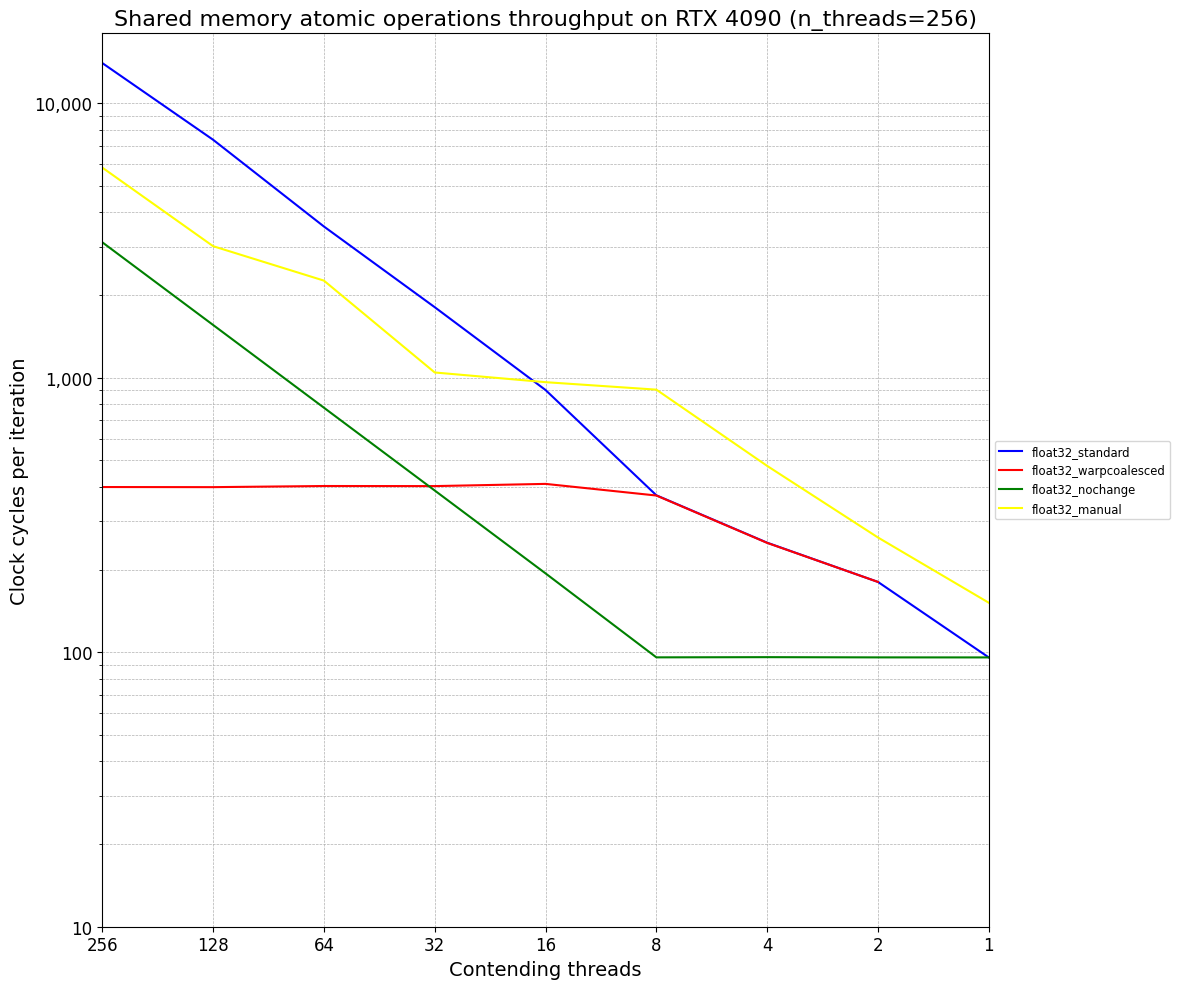

In [12]:
import math
import matplotlib.pyplot as plt
from collections import defaultdict

operation_colors = {
    "standard": "blue",
    "warpcoalesced": "red",
    "nochange": "green",
    "manual": "yellow",
}

# Define line styles for each dtype
dtype_styles = {
    "float32": "solid",
    "uint32": "dashed",
    "int64": "dotted",
    "half2": "dashdot",
    "double": (0, (3, 5, 1, 5))  # Custom dash pattern
}

def parse_key(key):
    return key.split("_")

for n_threads in (256,):
    values = list(results[n_threads].items())
    values.sort(key=lambda a: a[1][0])
    n_values = math.ceil(math.log2(n_threads) + 1)

    grouped_lines = defaultdict(list)
    for dtype_op, data in values:
        if dtype_op.startswith("add_") and dtype_op.count("_") == 2:
            grouped_lines[dtype_op.split("_")[1]].append((dtype_op.split("_")[2], data))
        elif dtype_op.count("_") == 1 and dtype_op.startswith("add_"):
            grouped_lines["standard"].append((dtype_op.split("_")[1], data))
    
    print(f"{grouped_lines.keys()=}")

    plt.figure(figsize=(14, 10))  # Set a larger figure size for better legibility

    for op, data_list in grouped_lines.items():
        for dtype, data in data_list:
            if dtype != 'float32': continue
            color = operation_colors[op]
            linestyle = dtype_styles.get(dtype, "solid")
            plt.plot([a / 512 for a in data[:n_values]], label=f"{dtype}_{op}", color=color, linestyle=linestyle)

    plt.title(f"Shared memory atomic operations throughput on RTX 4090 (n_threads={n_threads})", fontsize=16)
    plt.ylabel("Clock cycles per iteration", fontsize=14)
    plt.xlabel("Contending threads", fontsize=14)
    plt.yscale("log")
    plt.xticks(list(range(n_values)), [math.ceil(n_threads / (2**i)) for i in range(n_values)], fontsize=12)
    plt.yticks([10, 100, 1000, 10000], ["10", "100", "1,000", "10,000"], fontsize=12)
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)

    # Adjust x-axis limits to remove whitespace
    plt.xlim(0, n_values - 1)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legends

    plt.show()